In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

Dataset: Covid 19 Dataset (Kaggle)

In [3]:
train_dir = "C:/Users/DELL/OneDrive/Desktop/Afraa/Freelance/MLE/3.Image_classification/Covid19-dataset/train"
test_dir = "C:/Users/DELL/OneDrive/Desktop/Afraa/Freelance/MLE/3.Image_classification/Covid19-dataset/test"

img_size = 224
batch_size = 32


Data Augmentation and Loading

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

train_data.class_indices

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

Build CNN Model

In [5]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')  # 3 classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

Model Training

In [6]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "../model/covid_model.h5",
    monitor='val_accuracy',
    save_best_only=True
)

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
8/8 [==============================] - ETA: 0s - loss: 2.0221 - accuracy: 0.3904

c:\Users\DELL\OneDrive\Desktop\Afraa\Freelance\MLE\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 16s 2s/step - loss: 2.0221 - accuracy: 0.3904 - val_loss: 1.0037 - val_accuracy: 0.7424
Epoch 2/20
8/8 [==============================] - 15s 2s/step - loss: 0.8790 - accuracy: 0.6454 - val_loss: 0.5429 - val_accuracy: 0.8333
Epoch 3/20
8/8 [==============================] - 13s 2s/step - loss: 0.5727 - accuracy: 0.7649 - val_loss: 0.3814 - val_accuracy: 0.8485
Epoch 4/20
8/8 [==============================] - 13s 2s/step - loss: 0.6777 - accuracy: 0.7450 - val_loss: 0.7786 - val_accuracy: 0.6061
Epoch 5/20
8/8 [==============================] - 13s 2s/step - loss: 0.6153 - accuracy: 0.7131 - val_loss: 0.4961 - val_accuracy: 0.7576
Epoch 6/20
8/8 [==============================] - 13s 2s/step - loss: 0.4704 - accuracy: 0.8048 - val_loss: 0.4680 - val_accuracy: 0.7576
Epoch 7/20
8/8 [==============================] - 13s 2s/step - loss: 0.4607 - accuracy: 0.8048 - val_loss: 0.4406 - val_accuracy: 0.7576
Epoch 8/20
8/8 [=============================

Plot Accuracy and Loss

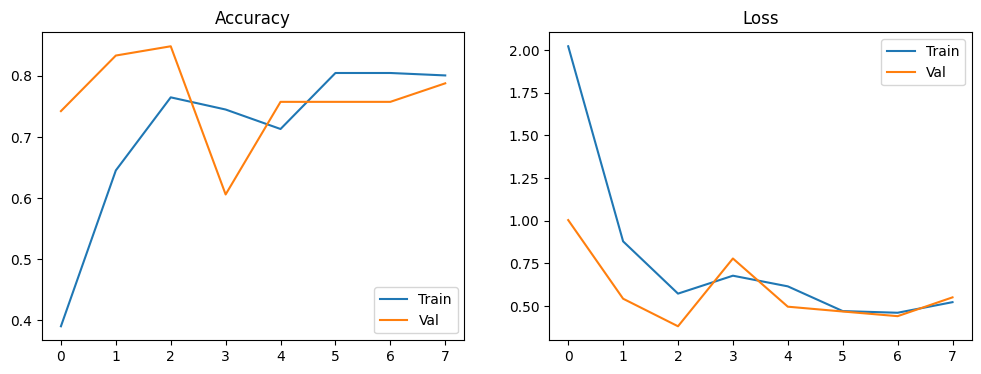

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['Train', 'Val'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['Train', 'Val'])

plt.show()

Save Model

In [8]:
model.save("../model/covid_model.h5")
print("Model Saved Successfully!")

Model Saved Successfully!


In [10]:
from keras.preprocessing import image

class_labels = list(train_data.class_indices.keys())

def predict_xray(img_path):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    confidence = float(np.max(prediction))

    return {
        "class": class_labels[class_index],
        "confidence": confidence
    }

# Test
predict_xray("C:/Users/DELL/OneDrive/Desktop/Afraa/Freelance/MLE/3.Image_classification/Covid19-dataset/test/Covid/094.png")

1/1 [==============================] - 0s 133ms/step


{'class': 'Covid', 'confidence': 0.9741398096084595}

In [11]:
predict_xray("C:/Users/DELL/OneDrive/Desktop/Afraa/Freelance/MLE/3.Image_classification/Covid19-dataset/test/Normal/0105.jpeg")

1/1 [==============================] - 0s 31ms/step


{'class': 'Normal', 'confidence': 0.8348021507263184}

In [12]:
predict_xray("C:/Users/DELL/OneDrive/Desktop/Afraa/Freelance/MLE/3.Image_classification/Covid19-dataset/test/Viral Pneumonia/0117.jpeg")

1/1 [==============================] - 0s 36ms/step


{'class': 'Viral Pneumonia', 'confidence': 0.8115684986114502}

In [13]:
predict_xray("C:/Users/DELL/Downloads/covid 19(1).png")

1/1 [==============================] - 0s 51ms/step


{'class': 'Normal', 'confidence': 0.49309760332107544}

In [14]:
predict_xray("C:/Users/DELL/Downloads/covid 19(2).png")

1/1 [==============================] - 0s 99ms/step


{'class': 'Covid', 'confidence': 0.826805055141449}